# Automated IAS identification approach using a Machine Learning approach

(Invasive alien species = IAS)

This is an independent thesis-project to classify <i>Rhamnus cathartica</i> using transfer learning in Convolutional Neural Networks (CNN).

All coding dependencies and datasets in this project is published under UWSpace with the original paper titled:
<br>__Identification of Invasive Plant Species using a Machine Learning approach__. 



---


This is test 6 with these parameters:
*   Bands: 4 8 11
*   Epochs = 100
*   Size = 6
*   Full dataset
*   **Test on images from November**

Other notes for this test:
*   **Added more test files from November**
*   Changed transforms to include flips (both horizontal and vertical)
*   Fixed dataset to include herbs and crops
*   Contains both types of crops (annual and perennial) as summer season should have no effect
*   Change size = 6 to size (6, 6) to squish image instead
*   Added notes




In [0]:
## saves data on Google Drive + links to datasets
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
## install latest version, but will cause conflicting import errors with old fastai versions
 !curl -s https://course.fast.ai/setup/colab | bash

## uncomment to install old version of fastai
## !pip install fastai==0.7.0
## !pip install torchtext==0.2.3


Updating fastai...
Done.


In [0]:
## install extra dependencies
!pip install rasterio    #used for transform images into JPG format, when needed, and select bands
!pip install sat-search  #used to easily obtain Sentinel-2A data - Link: https://github.com/sat-utils

## install GDAL
!apt install gdal-bin python-gdal python3-gdal 

    100% |████████████████████████████████| 19.7MB 2.0MB/s 
    100% |████████████████████████████████| 61kB 13.0MB/s 
    100% |████████████████████████████████| 235kB 33.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/9c/59/4d/591519a4f416d5fc87b2823e424b7ec2930623b06c3e25e76e
  Stored in directory: /root/.cache/pip/wheels/be/8d/49/43673c9c16ce8427f1b3a9441cd751b07e25e099b59e01a8f4
Successfully built sat-search sat-stac
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninst

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
## uncomment below to import fastai v0.7 packages instead
## from fastai.imports import *
## from fastai.conv_learner import *
## from fastai.model import *
## from fastai.plots import *


## import fastai v1 packages needed for image classification
from fastai.vision import *
from fastai.metrics import error_rate

## import rasterio + plotting
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

## import numpy
import numpy as np

## import GDAL
import gdal 

# import callbacks for training data
from fastai.callbacks import *

# histogram import via rasterio
from rasterio.plot import show_hist

# progress bar
from tqdm import tqdm

In [0]:
# show environment details
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.51
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Fri Apr 19 15:48:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+--

In [0]:
## list files and folders in the Google Drive connected
#!ls "/content/gdrive/My Drive"


In [0]:
## set main folder to the variable PATH as type Path
PATH = Path(base_dir + 'GEOG490data/')

## **Preprocessing**

#### Convert images to three selected bands and to .jpg format
bands 4, 8, 11 were selected

In [0]:
#note: band 12 is actually band 11, because of band 8A
#extract input folder data and class names
input_path = PATH/'input'
in_classes = [f for f in list(input_path.iterdir())]

#create new class directories in training folder (uncomment to create)
for i in tqdm(in_classes, desc="Creating directories for training"):
  if not os.path.isdir(Path(PATH/'train'/os.path.basename(i))):
    Path(PATH/'train'/os.path.basename(i)).mkdir(parents=True, exist_ok=False)

#convert Sentinel 13 bands .tiff files to RGB
#for i in in_classes:
#  in_files = list(i.iterdir())
#  for f in tqdm(in_files, desc="Class - " + str(os.path.basename(i))):
#    out_class = os.path.basename(i)
#    out_name = os.path.splitext(os.path.basename(f))[0]
#    os.environ['f_in'] = str(f)
#    os.environ['f_out'] = str(PATH/'train'/out_class/out_name)
#    if not Path(PATH/'train'/out_class/out_name).is_file(): # dont convert the image if it already exists
#      !gdal_translate -of JPEG -scale -b 4 -b 8 -b 12 "$f_in" "$f_out".jpg > RGB_out.log 2> /dev/null
      #print("Converted: " + out_name)

Creating directories for training: 100%|██████████| 10/10 [00:00<00:00, 2009.73it/s]


## Visualization

#### Classes and Size

Highway class has 400
River class has 400
Residential class has 400
RhamnusCathartica class has 421
Forest class has 400
Industrial class has 400
Pasture class has 400
SeaLake class has 400
Crop class has 400
HerbaceousVegetation class has 400


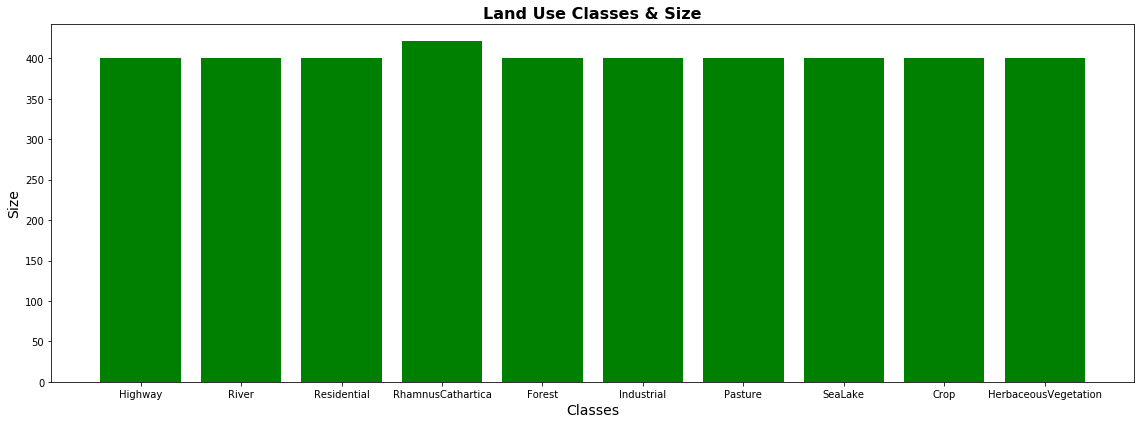

In [0]:
#extract training data and class names
train_path = PATH/'train'
classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

files = []
img_files = []
classes_num = {}
for i in classes:
    img_count = 0
    paths = train_path/i
    files.append(list(paths.iterdir())[0])
    for file in os.listdir(paths):
        if file.endswith(".jpg"):
            img_files.append(os.path.join(paths, file))
            img_count += 1
    classes_num[i] = img_count
    print(f'{i} class has ' + str(classes_num[i]))

    
plt.figure(figsize=(16,6))
plt.bar(classes_num.keys(), classes_num.values(), color='g')
plt.title('Land Use Classes & Size', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.tight_layout()
plt.savefig(PATH/'class_bargraph.jpg')

In [0]:
temp_dataset = rasterio.open(files[0])
temp_dataset.indexes

(1, 2, 3)

#### Images

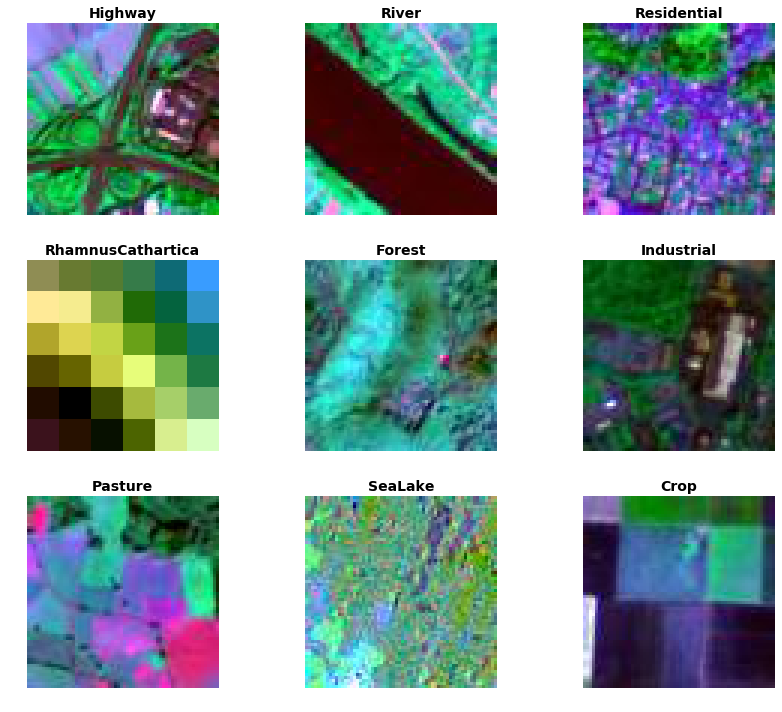

In [0]:
fig = plt.figure(figsize=(12,10))

# Open the file:
#fo = rasterio.open(files[0])

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def raster_to_RGB(raster):
  # Convert to numpy arrays
  red = raster.read(1)
  green = raster.read(2)
  blue = raster.read(3)
  # Normalize band DN
  redn = normalize(red)
  greenn = normalize(green)
  bluen = normalize(blue)
  # Stack bands
  return np.dstack((redn, greenn, bluen))


ax1 = plt.subplot(331);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[0])));ax1.set_title(classes[0], fontsize=14, fontweight='bold')
ax2 = plt.subplot(332);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[1])));ax2.set_title(classes[1], fontsize=14, fontweight='bold')
ax3 = plt.subplot(333);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[2])));ax3.set_title(classes[2], fontsize=14, fontweight='bold')

ax1 = plt.subplot(334);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[3])));ax1.set_title(classes[3], fontsize=14, fontweight='bold')
ax2 = plt.subplot(335);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[4])));ax2.set_title(classes[4], fontsize=14, fontweight='bold')
ax3 = plt.subplot(336);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[5])));ax3.set_title(classes[5], fontsize=14, fontweight='bold')

ax1 = plt.subplot(337);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[6])));ax1.set_title(classes[6], fontsize=14, fontweight='bold')
ax2 = plt.subplot(338);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[7])));ax2.set_title(classes[7], fontsize=14, fontweight='bold')
ax3 = plt.subplot(339);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[8])));ax3.set_title(classes[8], fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PATH/'class_sampleimg.jpg')

#### Histogram of Rhamnus Cathartica

File: /content/gdrive/My Drive/fastai-v3/GEOG490data/train/RhamnusCathartica/T15TWJ_20170706T170236_01.jpg


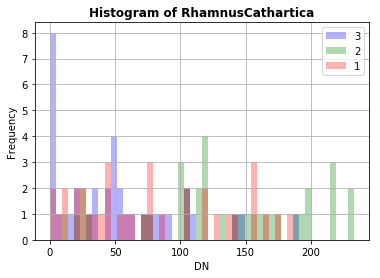

In [0]:
#convert to numpy arrays
raster_hist = rasterio.open(files[3])
print("File: " + str(files[3]))
hist_stack = []
hist_stack.append(raster_hist.read(1))
hist_stack.append(raster_hist.read(2))
hist_stack.append(raster_hist.read(3))
hist_arr = np.array(hist_stack)

show_hist(hist_arr, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of " + classes[3])

In [0]:
#show RGB histogram of Rhamnus Cathartica for tile 15TWK, made separately from ArcMap
raster_hist = rasterio.open(PATH/'15TWK_Rhamnus.tif')
print("File: " + str(PATH/'15TWK_Rhamnus.tif'))
#hist_stack = []
#hist_stack.append(raster_hist.read(4))
#hist_stack.append(raster_hist.read(3))
#hist_stack.append(raster_hist.read(2))
#hist_arr = np.array(hist_stack)

#show_hist(hist_arr, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="RGB Histogram of Rhamnus cathartica for tile 15TWK")

File: /content/gdrive/My Drive/fastai-v3/GEOG490data/15TWK_Rhamnus.tif


In [0]:
#show full histogram of Rhamnus Cathartica for tile 15TWK, made separately from ArcMap
raster_hist = rasterio.open(PATH/'15TWK_Rhamnus.tif')
print("File: " + str(PATH/'15TWK_Rhamnus.tif'))
#show_hist(raster_hist, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Full Histogram of Rhamnus cathartica for tile 15TWK")

File: /content/gdrive/My Drive/fastai-v3/GEOG490data/15TWK_Rhamnus.tif


## Model

In [0]:
#loading data into our model
train_in = str(PATH/"train")

tfms = get_transforms(do_flip=True, flip_vert=True)
data = (ImageList.from_folder(train_in)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms, size=(6,6))   # squishes the image to 6x6, instead of crop!
        .databunch())


print("Training directory set: " + train_in)

Training directory set: /content/gdrive/My Drive/fastai-v3/GEOG490data/train


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:02, 42179449.25it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


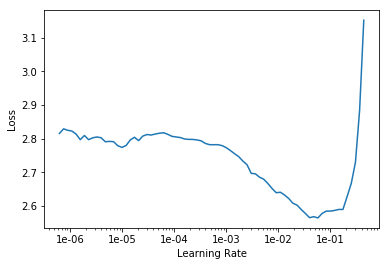

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
#choose low learning rate for fitting
lr = 1e-2

In [0]:
learn.fit_one_cycle(100, max_lr=lr, callbacks=[
                        SaveModelCallback(learn,
                                          every = 'improvement',
                                          monitor = 'error_rate',
                                          mode = 'min',
                                          name = 'rn50-stage1-best')])

epoch,train_loss,valid_loss,error_rate,time
0,2.390361,2.032206,0.639304,00:13
1,2.166093,1.773841,0.585821,00:11
2,2.045736,1.793097,0.572139,00:10
3,1.943062,1.809687,0.573383,00:10
4,1.827516,1.594152,0.543532,00:11
5,1.746795,1.535955,0.539801,00:11
6,1.704280,1.590417,0.513682,00:12
7,1.650897,1.782562,0.532338,00:11
8,1.607595,1.526106,0.541045,00:10
9,1.596757,1.429062,0.508706,00:10


Better model found at epoch 0 with error_rate value: 0.6393035054206848.
Better model found at epoch 1 with error_rate value: 0.5858209133148193.
Better model found at epoch 2 with error_rate value: 0.572139322757721.
Better model found at epoch 4 with error_rate value: 0.5435323119163513.
Better model found at epoch 5 with error_rate value: 0.5398010015487671.
Better model found at epoch 6 with error_rate value: 0.5136815905570984.
Better model found at epoch 9 with error_rate value: 0.5087064504623413.
Better model found at epoch 10 with error_rate value: 0.5012437701225281.
Better model found at epoch 12 with error_rate value: 0.48880597949028015.
Better model found at epoch 13 with error_rate value: 0.4788557291030884.
Better model found at epoch 14 with error_rate value: 0.4726368188858032.
Better model found at epoch 15 with error_rate value: 0.4353233873844147.
Better model found at epoch 24 with error_rate value: 0.41542288661003113.
Better model found at epoch 25 with error_ra

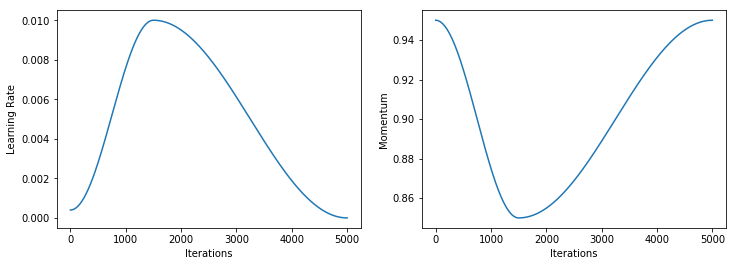

In [0]:
learn.recorder.plot_lr(show_moms=True)

## Analyzing results & Visualization

#### Plot training and validation losses

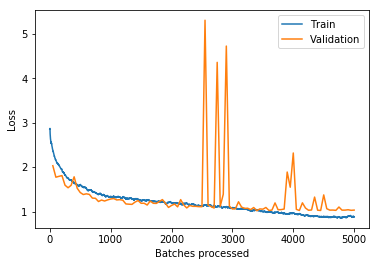

In [0]:
learn.recorder.plot_losses()

#### Evaluation of model

In [0]:
learn.load('rn50-stage1-best')

Learner(data=ImageDataBunch;

Train: LabelList (3217 items)
x: ImageList
Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6)
y: CategoryList
Highway,Highway,Highway,Highway,Highway
Path: /content/gdrive/My Drive/fastai-v3/GEOG490data/train;

Valid: LabelList (804 items)
x: ImageList
Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6),Image (3, 6, 6)
y: CategoryList
Crop,RhamnusCathartica,Highway,Pasture,Highway
Path: /content/gdrive/My Drive/fastai-v3/GEOG490data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64,

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

#### Top 9 misclassified samples, sorted by respective loss
Show images in top_losses along with their prediction, actual, loss, and probability of actual class. Uses Grad-CAM overview heatmap: where the model looks to make a decision.

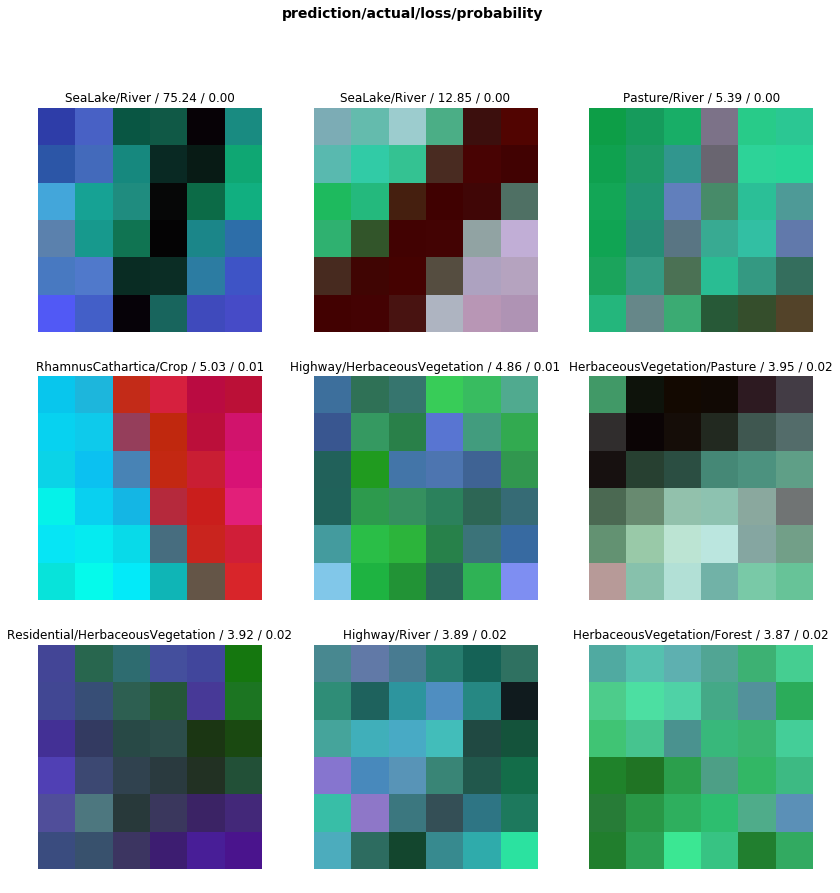

In [0]:
interp.plot_top_losses(9, figsize=(14,14))

#### Confusion matrix

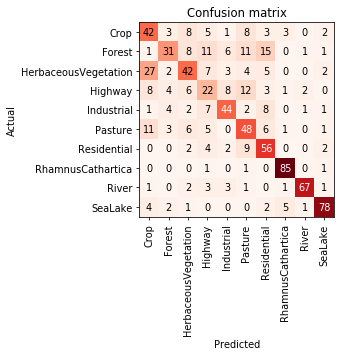

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), cmap='Reds', dpi=70)

In [0]:
interp.most_confused(min_val=2)

[('HerbaceousVegetation', 'Crop', 27),
 ('Forest', 'Residential', 15),
 ('Highway', 'Pasture', 12),
 ('Forest', 'Highway', 11),
 ('Forest', 'Pasture', 11),
 ('Pasture', 'Crop', 11),
 ('Residential', 'Pasture', 9),
 ('Crop', 'HerbaceousVegetation', 8),
 ('Crop', 'Pasture', 8),
 ('Forest', 'HerbaceousVegetation', 8),
 ('Highway', 'Crop', 8),
 ('Highway', 'Industrial', 8),
 ('Industrial', 'Residential', 8),
 ('HerbaceousVegetation', 'Highway', 7),
 ('Industrial', 'Highway', 7),
 ('Forest', 'Industrial', 6),
 ('Highway', 'HerbaceousVegetation', 6),
 ('Pasture', 'HerbaceousVegetation', 6),
 ('Pasture', 'Residential', 6),
 ('Crop', 'Highway', 5),
 ('HerbaceousVegetation', 'Residential', 5),
 ('Pasture', 'Highway', 5),
 ('SeaLake', 'RhamnusCathartica', 5),
 ('HerbaceousVegetation', 'Pasture', 4),
 ('Highway', 'Forest', 4),
 ('Industrial', 'Forest', 4),
 ('Residential', 'Highway', 4),
 ('SeaLake', 'Crop', 4),
 ('Crop', 'Forest', 3),
 ('Crop', 'Residential', 3),
 ('Crop', 'RhamnusCathartica', 3

### Experimenting on test data

#### Trial run on one test file

In [0]:
#convert test files to .JPG with specific bands
test_path = PATH/'test'
if not os.path.isdir(Path(PATH/'testJPG')):
  Path(PATH/'testJPG').mkdir(parents=True, exist_ok=False)

in_test_files = [f for f in list(test_path.iterdir()) if '.tif' in f.name]
for f in tqdm(in_test_files, desc="Processing test files"):
  out_name = os.path.splitext(os.path.basename(f))[0]
  os.environ['f_in'] = str(f)
  os.environ['f_out'] = str(PATH/'testJPG'/out_name)
  !gdal_translate -of JPEG -scale -b 4 -b 8 -b 11 "$f_in" "$f_out".jpg  > test_out.log 2> /dev/null
  print("Converted: " + out_name)

Processing test files:   1%|          | 1/110 [00:01<02:39,  1.46s/it]

Converted: T17TNJ_20170721T162051_01


Processing test files:   2%|▏         | 2/110 [00:02<02:19,  1.29s/it]

Converted: T17TNJ_20170721T162051_02


Processing test files:   3%|▎         | 3/110 [00:03<01:59,  1.12s/it]

Converted: T17TNJ_20170721T162051_03


Processing test files:   4%|▎         | 4/110 [00:03<01:48,  1.03s/it]

Converted: T17TNJ_20170721T162051_04


Processing test files:   5%|▍         | 5/110 [00:04<01:43,  1.02it/s]

Converted: T17TNJ_20170721T162051_05


Processing test files:   5%|▌         | 6/110 [00:05<01:34,  1.10it/s]

Converted: T17TNJ_20170721T162051_06


Processing test files:   6%|▋         | 7/110 [00:06<01:29,  1.15it/s]

Converted: T17TNJ_20170721T162051_07


Processing test files:   7%|▋         | 8/110 [00:07<01:26,  1.18it/s]

Converted: T17TNJ_20170721T162051_08


Processing test files:   8%|▊         | 9/110 [00:07<01:24,  1.20it/s]

Converted: T17TNJ_20170721T162051_09


Processing test files:   9%|▉         | 10/110 [00:08<01:22,  1.21it/s]

Converted: T17TNJ_20170721T162051_10


Processing test files:  10%|█         | 11/110 [00:09<01:21,  1.22it/s]

Converted: T17TNJ_20170721T162051_11


Processing test files:  11%|█         | 12/110 [00:10<01:19,  1.23it/s]

Converted: T17TNJ_20170721T162051_12


Processing test files:  12%|█▏        | 13/110 [00:11<01:18,  1.23it/s]

Converted: T17TNJ_20170721T162051_13


Processing test files:  13%|█▎        | 14/110 [00:12<01:22,  1.16it/s]

Converted: T17TNJ_20170721T162051_14


Processing test files:  14%|█▎        | 15/110 [00:12<01:20,  1.18it/s]

Converted: T15TWN_20171128T204028_01


Processing test files:  15%|█▍        | 16/110 [00:13<01:18,  1.20it/s]

Converted: T15TWN_20171128T204028_02


Processing test files:  15%|█▌        | 17/110 [00:14<01:16,  1.22it/s]

Converted: T15TWN_20171128T204028_03


Processing test files:  16%|█▋        | 18/110 [00:15<01:14,  1.23it/s]

Converted: T15TWN_20171128T204028_04


Processing test files:  17%|█▋        | 19/110 [00:16<01:13,  1.23it/s]

Converted: T15TWN_20171128T204028_05


Processing test files:  18%|█▊        | 20/110 [00:16<01:12,  1.24it/s]

Converted: T15TWN_20171128T204028_06


Processing test files:  19%|█▉        | 21/110 [00:17<01:11,  1.24it/s]

Converted: T15TWN_20171128T204028_07


Processing test files:  20%|██        | 22/110 [00:18<01:10,  1.25it/s]

Converted: T15TWN_20171128T204028_08


Processing test files:  21%|██        | 23/110 [00:19<01:09,  1.25it/s]

Converted: T15TWN_20171128T204028_09


Processing test files:  22%|██▏       | 24/110 [00:20<01:11,  1.20it/s]

Converted: T15TWN_20171128T204028_10


Processing test files:  23%|██▎       | 25/110 [00:20<01:08,  1.24it/s]

Converted: T15TWN_20171128T204028_11


Processing test files:  24%|██▎       | 26/110 [00:21<01:06,  1.26it/s]

Converted: T15TWN_20171128T204028_12


Processing test files:  25%|██▍       | 27/110 [00:22<01:06,  1.24it/s]

Converted: T15TWN_20171128T204028_13


Processing test files:  25%|██▌       | 28/110 [00:23<01:09,  1.18it/s]

Converted: T15TWN_20171128T204028_14


Processing test files:  26%|██▋       | 29/110 [00:24<01:08,  1.19it/s]

Converted: T15TWN_20171128T204028_15


Processing test files:  27%|██▋       | 30/110 [00:25<01:11,  1.13it/s]

Converted: T15TWN_20171128T204028_16


Processing test files:  28%|██▊       | 31/110 [00:26<01:07,  1.17it/s]

Converted: T15TWN_20171128T204028_17


Processing test files:  29%|██▉       | 32/110 [00:26<01:03,  1.23it/s]

Converted: T15TWN_20171128T204028_18


Processing test files:  30%|███       | 33/110 [00:27<01:02,  1.24it/s]

Converted: T15TWN_20171128T204028_19


Processing test files:  31%|███       | 34/110 [00:28<01:01,  1.24it/s]

Converted: T15TWN_20171128T204028_20


Processing test files:  32%|███▏      | 35/110 [00:29<01:00,  1.24it/s]

Converted: T15TWN_20171128T204028_21


Processing test files:  33%|███▎      | 36/110 [00:29<00:59,  1.24it/s]

Converted: T15TWN_20171128T204028_22


Processing test files:  34%|███▎      | 37/110 [00:30<00:58,  1.24it/s]

Converted: T15TWN_20171128T204028_23


Processing test files:  35%|███▍      | 38/110 [00:31<00:57,  1.26it/s]

Converted: T15TWM_20171128T204028_01


Processing test files:  35%|███▌      | 39/110 [00:32<00:57,  1.25it/s]

Converted: T15TWM_20171128T204028_02


Processing test files:  36%|███▋      | 40/110 [00:33<00:55,  1.25it/s]

Converted: T15TWM_20171128T204028_03


Processing test files:  37%|███▋      | 41/110 [00:33<00:55,  1.25it/s]

Converted: T15TWM_20171128T204028_04


Processing test files:  38%|███▊      | 42/110 [00:34<00:54,  1.24it/s]

Converted: T15TWM_20171128T204028_05


Processing test files:  39%|███▉      | 43/110 [00:35<00:53,  1.25it/s]

Converted: T15TWM_20171128T204028_06


Processing test files:  40%|████      | 44/110 [00:36<00:52,  1.25it/s]

Converted: T15TWM_20171128T204028_07


Processing test files:  41%|████      | 45/110 [00:37<00:55,  1.17it/s]

Converted: T15TWM_20171128T204028_08


Processing test files:  42%|████▏     | 46/110 [00:38<00:54,  1.18it/s]

Converted: T15TWM_20171128T204028_09


Processing test files:  43%|████▎     | 47/110 [00:38<00:52,  1.21it/s]

Converted: T15TWM_20171128T204028_10


Processing test files:  44%|████▎     | 48/110 [00:39<00:51,  1.20it/s]

Converted: T15TWM_20171128T204028_11


Processing test files:  45%|████▍     | 49/110 [00:40<00:49,  1.22it/s]

Converted: T15TWM_20171128T204028_12


Processing test files:  45%|████▌     | 50/110 [00:41<00:49,  1.21it/s]

Converted: T15TWM_20171128T204028_13


Processing test files:  46%|████▋     | 51/110 [00:42<00:47,  1.25it/s]

Converted: T15TWM_20171128T204028_14


Processing test files:  47%|████▋     | 52/110 [00:42<00:46,  1.24it/s]

Converted: T15TWM_20171128T204028_15


Processing test files:  48%|████▊     | 53/110 [00:43<00:45,  1.25it/s]

Converted: T15TWM_20171128T204028_16


Processing test files:  49%|████▉     | 54/110 [00:44<00:44,  1.26it/s]

Converted: T15TWM_20171128T204028_17


Processing test files:  50%|█████     | 55/110 [00:45<00:44,  1.25it/s]

Converted: T15TWM_20171128T204028_18


Processing test files:  51%|█████     | 56/110 [00:46<00:45,  1.20it/s]

Converted: T15TWM_20171128T204028_19


Processing test files:  52%|█████▏    | 57/110 [00:47<00:43,  1.22it/s]

Converted: T15TWM_20171128T204028_20


Processing test files:  53%|█████▎    | 58/110 [00:47<00:42,  1.22it/s]

Converted: T15TWM_20171128T204028_21


Processing test files:  54%|█████▎    | 59/110 [00:48<00:41,  1.24it/s]

Converted: T15TWM_20171128T204028_22


Processing test files:  55%|█████▍    | 60/110 [00:49<00:40,  1.23it/s]

Converted: T15TWM_20171128T204028_23


Processing test files:  55%|█████▌    | 61/110 [00:50<00:39,  1.24it/s]

Converted: T15TWM_20171128T204028_24


Processing test files:  56%|█████▋    | 62/110 [00:50<00:37,  1.29it/s]

Converted: T15TWM_20171128T204028_25


Processing test files:  57%|█████▋    | 63/110 [00:51<00:35,  1.31it/s]

Converted: T15TWM_20171128T204028_26


Processing test files:  58%|█████▊    | 64/110 [00:52<00:34,  1.32it/s]

Converted: T15TWM_20171128T204028_27


Processing test files:  59%|█████▉    | 65/110 [00:53<00:34,  1.29it/s]

Converted: T15TWM_20171128T204028_28


Processing test files:  60%|██████    | 66/110 [00:54<00:34,  1.29it/s]

Converted: T15TWM_20171128T204028_29


Processing test files:  61%|██████    | 67/110 [00:54<00:33,  1.27it/s]

Converted: T15TWM_20171128T204028_30


Processing test files:  62%|██████▏   | 68/110 [00:55<00:33,  1.26it/s]

Converted: T15TWM_20171128T204028_31


Processing test files:  63%|██████▎   | 69/110 [00:56<00:32,  1.26it/s]

Converted: T15TWM_20171128T204028_32


Processing test files:  64%|██████▎   | 70/110 [00:57<00:31,  1.25it/s]

Converted: T15TWM_20171128T204028_33


Processing test files:  65%|██████▍   | 71/110 [00:58<00:32,  1.21it/s]

Converted: T15TWM_20171128T204028_34


Processing test files:  65%|██████▌   | 72/110 [00:58<00:31,  1.22it/s]

Converted: T15TWM_20171128T204028_35


Processing test files:  66%|██████▋   | 73/110 [00:59<00:30,  1.21it/s]

Converted: T15TWM_20171128T204028_36


Processing test files:  67%|██████▋   | 74/110 [01:00<00:28,  1.25it/s]

Converted: T15TWM_20171128T204028_37


Processing test files:  68%|██████▊   | 75/110 [01:01<00:28,  1.24it/s]

Converted: T15TWM_20171128T204028_38


Processing test files:  69%|██████▉   | 76/110 [01:02<00:28,  1.20it/s]

Converted: T15TWM_20171128T204028_39


Processing test files:  70%|███████   | 77/110 [01:03<00:27,  1.21it/s]

Converted: T15TWM_20171128T204028_40


Processing test files:  71%|███████   | 78/110 [01:03<00:26,  1.23it/s]

Converted: T15TWM_20171128T204028_41


Processing test files:  72%|███████▏  | 79/110 [01:04<00:25,  1.24it/s]

Converted: T15TWM_20171128T204028_42


Processing test files:  73%|███████▎  | 80/110 [01:05<00:23,  1.27it/s]

Converted: T15TWM_20171128T204028_43


Processing test files:  74%|███████▎  | 81/110 [01:06<00:23,  1.26it/s]

Converted: T15TWM_20171128T204028_44


Processing test files:  75%|███████▍  | 82/110 [01:06<00:22,  1.27it/s]

Converted: T15TWM_20171128T204028_45


Processing test files:  75%|███████▌  | 83/110 [01:07<00:21,  1.27it/s]

Converted: T15TWM_20171128T204028_46


Processing test files:  76%|███████▋  | 84/110 [01:08<00:20,  1.27it/s]

Converted: T15TWM_20171128T204028_47


Processing test files:  77%|███████▋  | 85/110 [01:09<00:19,  1.27it/s]

Converted: T15TWM_20171128T204028_48


Processing test files:  78%|███████▊  | 86/110 [01:10<00:19,  1.26it/s]

Converted: T15TWM_20171128T204028_49


Processing test files:  79%|███████▉  | 87/110 [01:10<00:17,  1.30it/s]

Converted: T15TWM_20171128T204028_50


Processing test files:  80%|████████  | 88/110 [01:11<00:17,  1.28it/s]

Converted: T15TWM_20171128T204028_51


Processing test files:  81%|████████  | 89/110 [01:12<00:16,  1.27it/s]

Converted: T15TWM_20171128T204028_52


Processing test files:  82%|████████▏ | 90/110 [01:13<00:15,  1.30it/s]

Converted: T15TWM_20171128T204028_53


Processing test files:  83%|████████▎ | 91/110 [01:13<00:14,  1.31it/s]

Converted: T15TWM_20171128T204028_54


Processing test files:  84%|████████▎ | 92/110 [01:14<00:14,  1.29it/s]

Converted: T15TWM_20171128T204028_55


Processing test files:  85%|████████▍ | 93/110 [01:15<00:13,  1.31it/s]

Converted: T15TWM_20171128T204028_56


Processing test files:  85%|████████▌ | 94/110 [01:16<00:12,  1.31it/s]

Converted: T15TWM_20171128T204028_57


Processing test files:  86%|████████▋ | 95/110 [01:17<00:11,  1.27it/s]

Converted: T15TWM_20171128T204028_58


Processing test files:  87%|████████▋ | 96/110 [01:17<00:10,  1.30it/s]

Converted: T15TWM_20171128T204028_59


Processing test files:  88%|████████▊ | 97/110 [01:18<00:09,  1.31it/s]

Converted: T15TWM_20171128T204028_60


Processing test files:  89%|████████▉ | 98/110 [01:19<00:09,  1.30it/s]

Converted: T15TWM_20171128T204028_61


Processing test files:  90%|█████████ | 99/110 [01:20<00:08,  1.29it/s]

Converted: T15TWM_20171128T204028_62


Processing test files:  91%|█████████ | 100/110 [01:20<00:07,  1.31it/s]

Converted: T15TWM_20171128T204028_63


Processing test files:  92%|█████████▏| 101/110 [01:21<00:06,  1.30it/s]

Converted: T15TWM_20171128T204028_64


Processing test files:  93%|█████████▎| 102/110 [01:22<00:06,  1.29it/s]

Converted: T15TWM_20171128T204028_65


Processing test files:  94%|█████████▎| 103/110 [01:23<00:05,  1.28it/s]

Converted: T15TWM_20171128T204028_66


Processing test files:  95%|█████████▍| 104/110 [01:24<00:04,  1.27it/s]

Converted: T15TWM_20171128T204028_67


Processing test files:  95%|█████████▌| 105/110 [01:24<00:03,  1.25it/s]

Converted: T15TWM_20171128T204028_68


Processing test files:  96%|█████████▋| 106/110 [01:25<00:03,  1.25it/s]

Converted: T15TWM_20171128T204028_69


Processing test files:  97%|█████████▋| 107/110 [01:26<00:02,  1.26it/s]

Converted: T15TWM_20171128T204028_70


Processing test files:  98%|█████████▊| 108/110 [01:27<00:01,  1.26it/s]

Converted: T15TWM_20171128T204028_71


Processing test files:  99%|█████████▉| 109/110 [01:28<00:00,  1.21it/s]

Converted: T15TWM_20171128T204028_72


Processing test files: 100%|██████████| 110/110 [01:28<00:00,  1.21it/s]

Converted: T15TWM_20171128T204028_73


In [0]:
#load test data
test_path = PATH/'testJPG'
test_files = [f for f in list(test_path.iterdir()) if not '.xml' in f.name]
print(len(test_files))

110


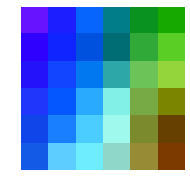

In [0]:
#sample image from ontario
img = open_image(test_files[1])
img.show()

In [0]:
learn.predict(img)

(Category RhamnusCathartica,
 tensor(7),
 tensor([1.5052e-04, 1.0100e-05, 6.2197e-06, 3.9819e-05, 4.6612e-06, 3.0617e-05,
         1.4583e-06, 9.9944e-01, 4.3935e-05, 2.7032e-04]))

#### Confidence and assessment of test data

In [0]:
preds = []
pred_classes = []
for fn in test_files:
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [f.name for f in test_files[:len(preds)]]
df['predicted_class'] = pred_classes
pd.set_option('display.max_rows', 500)
df.head(110)

,Crop,Forest,HerbaceousVegetation,Highway,Industrial,Pasture,Residential,RhamnusCathartica,River,SeaLake,fname,predicted_class
0,3.815833e-03,3.828230e-04,1.970530e-03,4.048703e-03,3.558902e-04,8.154601e-03,1.150252e-04,0.978355,8.710584e-04,1.930244e-03,T17TNJ_20170721T162051_01.jpg,RhamnusCathartica
1,1.505200e-04,1.009955e-05,6.219651e-06,3.981888e-05,4.661219e-06,3.061715e-05,1.458274e-06,0.999442,4.393549e-05,2.703218e-04,T17TNJ_20170721T162051_02.jpg,RhamnusCathartica
2,1.111293e-04,1.770823e-05,3.410762e-06,3.776793e-05,3.116051e-06,6.018200e-05,1.151878e-06,0.999691,6.377951e-05,1.128060e-05,T17TNJ_20170721T162051_03.jpg,RhamnusCathartica
3,2.798330e-02,2.568355e-03,2.735528e-03,2.428182e-02,2.658855e-03,3.439498e-02,3.111120e-04,0.609356,2.927870e-01,2.922701e-03,T17TNJ_20170721T162051_04.jpg,RhamnusCathartica
4,4.892780e-03,3.320761e-05,1.318675e-04,1.633799e-04,4.997089e-05,1.277208e-04,2.428631e-05,0.976830,1.389492e-02,3.851402e-03,T17TNJ_20170721T162051_05.jpg,RhamnusCathartica
5,1.390236e-01,2.170716e-02,1.166625e-01,1.286075e-01,8.789707e-03,4.472541e-01,5.141418e-03,0.071291,5.490950e-02,6.613864e-03,T17TNJ_20170721T162051_06.jpg,Pasture
6,3.944231e-03,2.395713e-02,2.429437e-03,2.659478e-02,7.794191e-03,4.717148e-01,1.682931e-03,0.451495,9.390455e-03,9.974642e-04,T17TNJ_20170721T162051_07.jpg,Pasture
7,9.561862e-03,7.790347e-05,6.718194e-04,4.504717e-04,1.906879e-04,5.176811e-04,4.718168e-05,0.983108,5.485514e-04,4.825803e-03,T17TNJ_20170721T162051_08.jpg,RhamnusCathartica
8,1.247144e-04,1.047270e-06,1.928864e-06,8.820391e-06,1.421965e-06,6.071487e-06,7.310364e-07,0.999805,3.019157e-05,1.992960e-05,T17TNJ_20170721T162051_09.jpg,RhamnusCathartica
9,5.969792e-05,4.974314e-05,1.447787e-04,1.957675e-04,2.256802e-04,6.289459e-04,1.435196e-05,0.998431,1.078305e-04,1.426655e-04,T17TNJ_20170721T162051_10.jpg,RhamnusCathartica


ID 0 RhamnusCathartica  category confidence: 0.9783552885055542


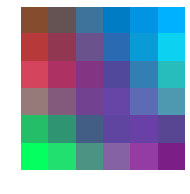

ID 1 RhamnusCathartica  category confidence: 0.9994422793388367


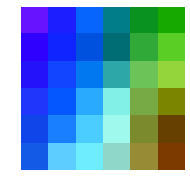

ID 2 RhamnusCathartica  category confidence: 0.9996905326843262


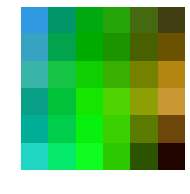

ID 3 RhamnusCathartica  category confidence: 0.6093564629554749


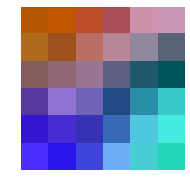

ID 4 RhamnusCathartica  category confidence: 0.9768304824829102


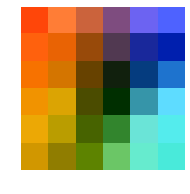

ID 5 Pasture  category confidence: 0.4472540616989136


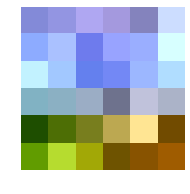

ID 6 Pasture  category confidence: 0.4717147946357727


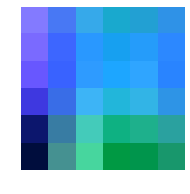

ID 7 RhamnusCathartica  category confidence: 0.9831079840660095


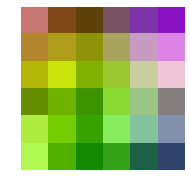

ID 8 RhamnusCathartica  category confidence: 0.9998051524162292


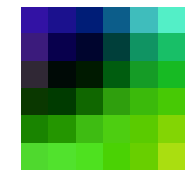

ID 9 RhamnusCathartica  category confidence: 0.9984305500984192


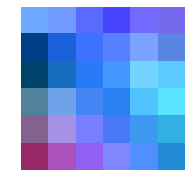

ID 10 Highway  category confidence: 0.2336375117301941


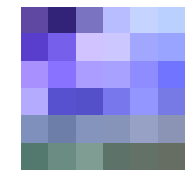

ID 11 RhamnusCathartica  category confidence: 0.8796459436416626


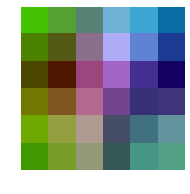

ID 12 RhamnusCathartica  category confidence: 0.7503218650817871


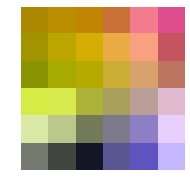

ID 13 RhamnusCathartica  category confidence: 0.9934796094894409


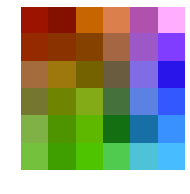

ID 14 RhamnusCathartica  category confidence: 0.9816569089889526


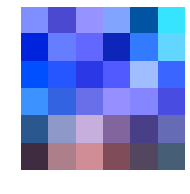

ID 15 RhamnusCathartica  category confidence: 0.8205394744873047


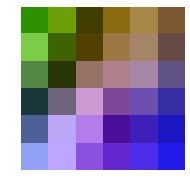

ID 16 RhamnusCathartica  category confidence: 0.8590768575668335


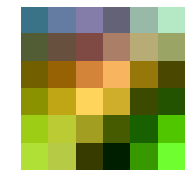

ID 17 RhamnusCathartica  category confidence: 0.9954267144203186


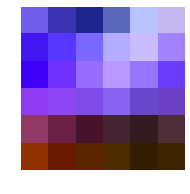

ID 18 River  category confidence: 0.9833353757858276


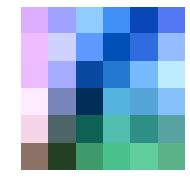

ID 19 RhamnusCathartica  category confidence: 0.9996583461761475


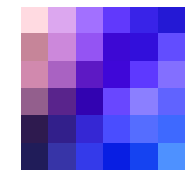

ID 20 RhamnusCathartica  category confidence: 0.944277286529541


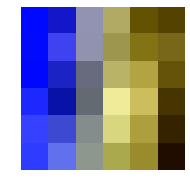

ID 21 RhamnusCathartica  category confidence: 0.9998540878295898


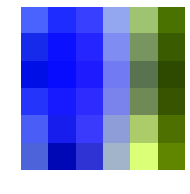

ID 22 RhamnusCathartica  category confidence: 0.8771234750747681


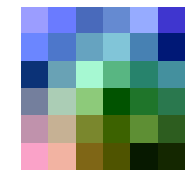

ID 23 RhamnusCathartica  category confidence: 0.9999943971633911


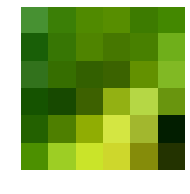

ID 24 RhamnusCathartica  category confidence: 0.9994012117385864


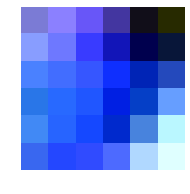

ID 25 RhamnusCathartica  category confidence: 0.5649702548980713


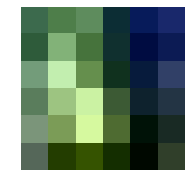

ID 26 RhamnusCathartica  category confidence: 0.9976297616958618


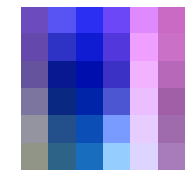

ID 27 RhamnusCathartica  category confidence: 0.9779671430587769


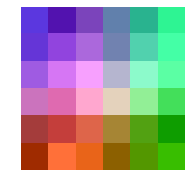

ID 28 RhamnusCathartica  category confidence: 0.9861131310462952


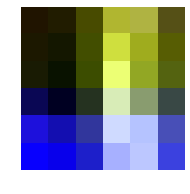

ID 29 RhamnusCathartica  category confidence: 0.9841763973236084


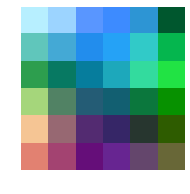

ID 30 RhamnusCathartica  category confidence: 0.9959715008735657


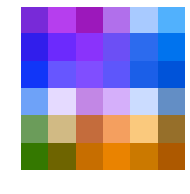

ID 31 RhamnusCathartica  category confidence: 0.6993979215621948


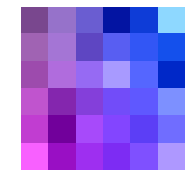

ID 32 RhamnusCathartica  category confidence: 0.9487947225570679


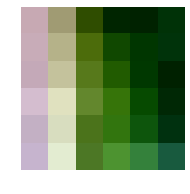

ID 33 RhamnusCathartica  category confidence: 0.9835451245307922


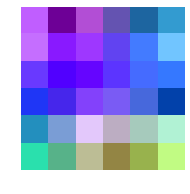

ID 34 RhamnusCathartica  category confidence: 0.9992478489875793


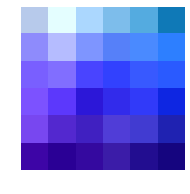

ID 35 RhamnusCathartica  category confidence: 0.9928027987480164


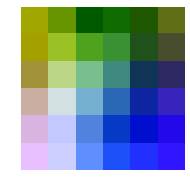

ID 36 RhamnusCathartica  category confidence: 0.9914906620979309


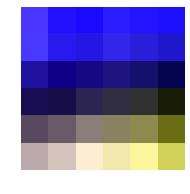

ID 37 RhamnusCathartica  category confidence: 0.9967727065086365


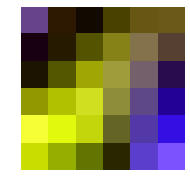

ID 38 RhamnusCathartica  category confidence: 0.9877759218215942


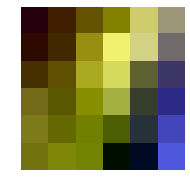

ID 39 RhamnusCathartica  category confidence: 0.9624488353729248


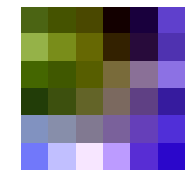

ID 40 RhamnusCathartica  category confidence: 0.9837191700935364


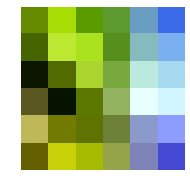

ID 41 RhamnusCathartica  category confidence: 0.7406607866287231


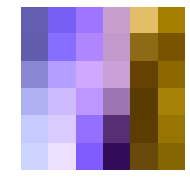

ID 42 RhamnusCathartica  category confidence: 0.7283948063850403


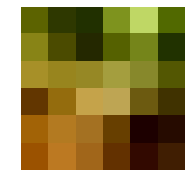

ID 43 RhamnusCathartica  category confidence: 0.9869568347930908


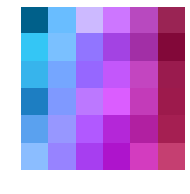

ID 44 RhamnusCathartica  category confidence: 0.9860535264015198


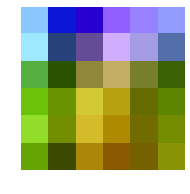

ID 45 RhamnusCathartica  category confidence: 0.9960423707962036


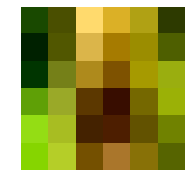

ID 46 RhamnusCathartica  category confidence: 0.8606477379798889


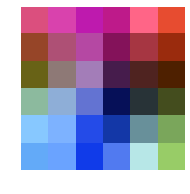

ID 47 RhamnusCathartica  category confidence: 0.9793320894241333


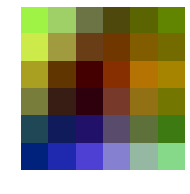

ID 48 RhamnusCathartica  category confidence: 0.9724395871162415


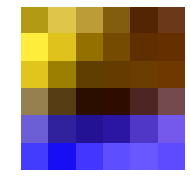

ID 49 RhamnusCathartica  category confidence: 0.9957311749458313


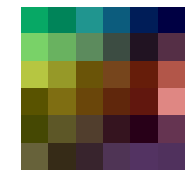

ID 50 RhamnusCathartica  category confidence: 0.7779853343963623


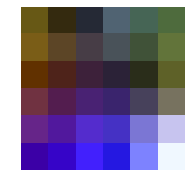

ID 51 RhamnusCathartica  category confidence: 0.9996911287307739


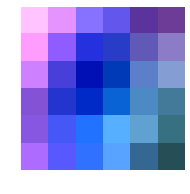

ID 52 RhamnusCathartica  category confidence: 0.9957531690597534


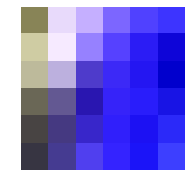

ID 53 SeaLake  category confidence: 0.8998113870620728


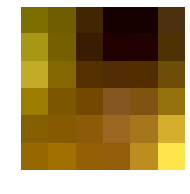

ID 54 RhamnusCathartica  category confidence: 0.9963828325271606


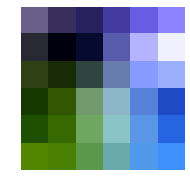

ID 55 RhamnusCathartica  category confidence: 0.6500052809715271


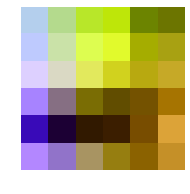

ID 56 RhamnusCathartica  category confidence: 0.9805951118469238


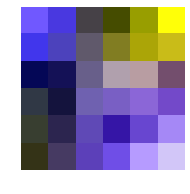

ID 57 RhamnusCathartica  category confidence: 0.9957311749458313


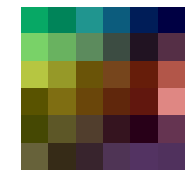

ID 58 RhamnusCathartica  category confidence: 0.7406607866287231


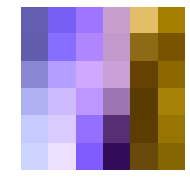

ID 59 RhamnusCathartica  category confidence: 0.6517332196235657


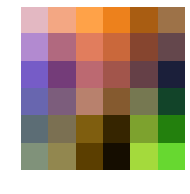

ID 60 RhamnusCathartica  category confidence: 0.9942314624786377


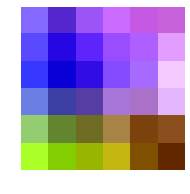

ID 61 RhamnusCathartica  category confidence: 0.9421424865722656


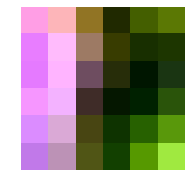

ID 62 RhamnusCathartica  category confidence: 0.9762486815452576


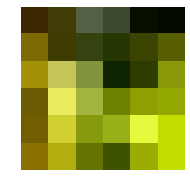

ID 63 RhamnusCathartica  category confidence: 0.9935376048088074


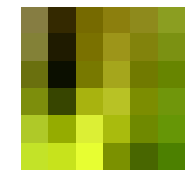

ID 64 RhamnusCathartica  category confidence: 0.9762486815452576


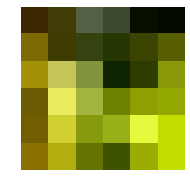

ID 65 RhamnusCathartica  category confidence: 0.9880008101463318


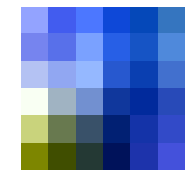

ID 66 RhamnusCathartica  category confidence: 0.9590532779693604


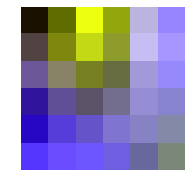

ID 67 RhamnusCathartica  category confidence: 0.9936124682426453


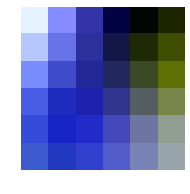

ID 68 RhamnusCathartica  category confidence: 0.6859068274497986


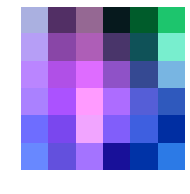

ID 69 RhamnusCathartica  category confidence: 0.9853876233100891


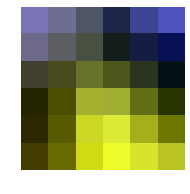

ID 70 HerbaceousVegetation  category confidence: 0.4861200451850891


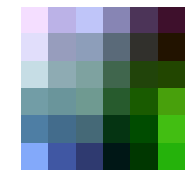

ID 71 RhamnusCathartica  category confidence: 0.9937964677810669


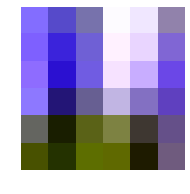

ID 72 RhamnusCathartica  category confidence: 0.9526829719543457


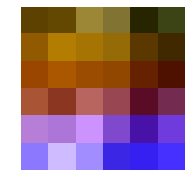

ID 73 RhamnusCathartica  category confidence: 0.9251844882965088


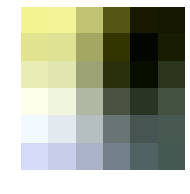

ID 74 RhamnusCathartica  category confidence: 0.993740439414978


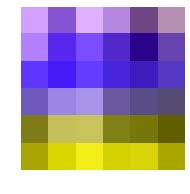

ID 75 RhamnusCathartica  category confidence: 0.9773548245429993


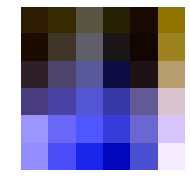

ID 76 RhamnusCathartica  category confidence: 0.993740439414978


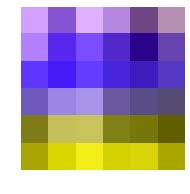

ID 77 RhamnusCathartica  category confidence: 0.9686222672462463


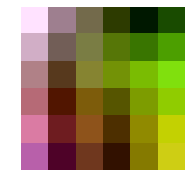

ID 78 RhamnusCathartica  category confidence: 0.767782986164093


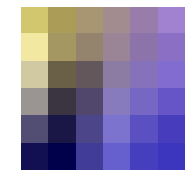

ID 79 RhamnusCathartica  category confidence: 0.9437741041183472


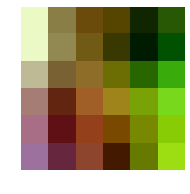

ID 80 RhamnusCathartica  category confidence: 0.9266371726989746


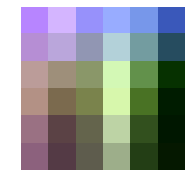

ID 81 RhamnusCathartica  category confidence: 0.9864830374717712


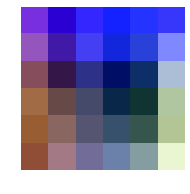

ID 82 RhamnusCathartica  category confidence: 0.992194652557373


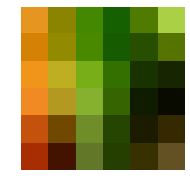

ID 83 RhamnusCathartica  category confidence: 0.8735403418540955


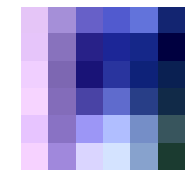

ID 84 RhamnusCathartica  category confidence: 0.8777021765708923


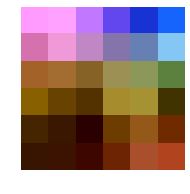

ID 85 RhamnusCathartica  category confidence: 0.9465640783309937


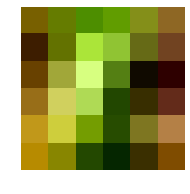

ID 86 RhamnusCathartica  category confidence: 0.9465640783309937


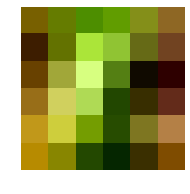

ID 87 RhamnusCathartica  category confidence: 0.8190430402755737


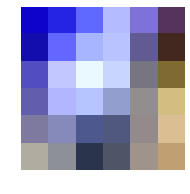

ID 88 RhamnusCathartica  category confidence: 0.7211767435073853


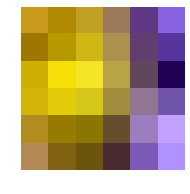

ID 89 RhamnusCathartica  category confidence: 0.9999990463256836


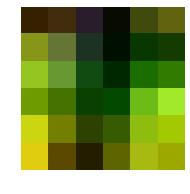

ID 90 RhamnusCathartica  category confidence: 0.9426625370979309


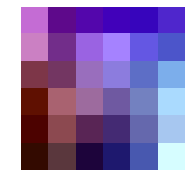

ID 91 RhamnusCathartica  category confidence: 0.7211767435073853


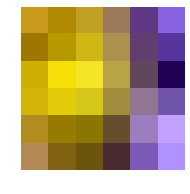

ID 92 RhamnusCathartica  category confidence: 0.7775402665138245


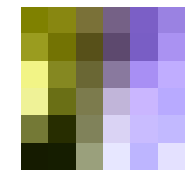

ID 93 RhamnusCathartica  category confidence: 0.5872623324394226


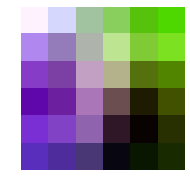

ID 94 River  category confidence: 0.9744096398353577


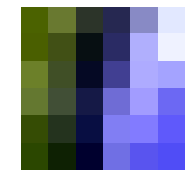

ID 95 RhamnusCathartica  category confidence: 0.9607932567596436


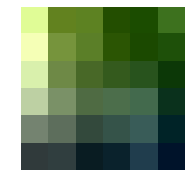

ID 96 RhamnusCathartica  category confidence: 0.9549483060836792


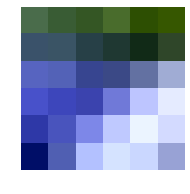

ID 97 RhamnusCathartica  category confidence: 0.9894528388977051


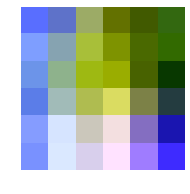

ID 98 RhamnusCathartica  category confidence: 0.9894528388977051


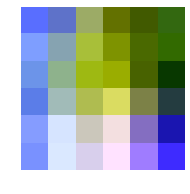

ID 99 RhamnusCathartica  category confidence: 0.8646256327629089


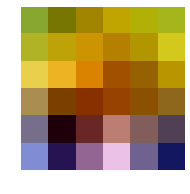

ID 100 RhamnusCathartica  category confidence: 0.986631453037262


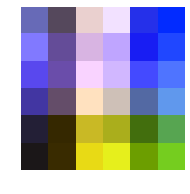

ID 101 RhamnusCathartica  category confidence: 0.9955543875694275


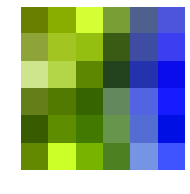

ID 102 RhamnusCathartica  category confidence: 0.6561089754104614


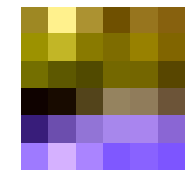

ID 103 RhamnusCathartica  category confidence: 0.9066948294639587


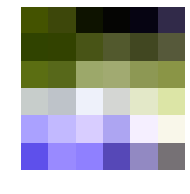

ID 104 RhamnusCathartica  category confidence: 0.9551388025283813


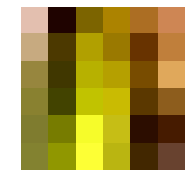

ID 105 RhamnusCathartica  category confidence: 0.9817752838134766


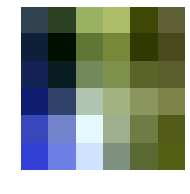

ID 106 RhamnusCathartica  category confidence: 0.9964281916618347


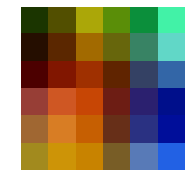

ID 107 RhamnusCathartica  category confidence: 0.9793983101844788


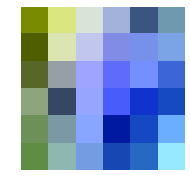

ID 108 RhamnusCathartica  category confidence: 0.962971031665802


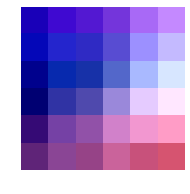

ID 109 RhamnusCathartica  category confidence: 0.8186418414115906


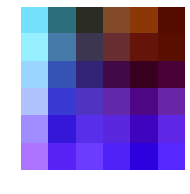

In [0]:
for i in range(110):
    img = open_image(test_path/df.iloc[i]['fname'])
    print("ID", str(i), df.iloc[i]['predicted_class'], ' category confidence:', df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()